In [1]:
!pip install segmentation-models-pytorch

In [2]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to c:\windows\temp\pip-req-build-sqfiu38y
  Resolved https://github.com/albumentations-team/albumentations to commit a3a8fd99b564663e26a741c6d59013f2f213c799


  Running command git clone -q https://github.com/albumentations-team/albumentations 'C:\Windows\Temp\pip-req-build-sqfiu38y'


In [3]:
!pip install --upgrade opencv-contrib-python

In [4]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


In [5]:
import sys
sys.path.append('./Human-Segmentation-Dataset-master')

In [6]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import platform
if 'Linux' in platform.system():
    import grp
 
if 'Windows' in platform.system():
    pass

D:\ProgramData\Anaconda3\envs\pytroch-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def print_cuda_statistics():
    import sys
    from subprocess import call
    import torch
    print('__Python VERSION:  {}'.format(sys.version))
    print('__pyTorch VERSION:  {}'.format(torch.__version__))
    print('__CUDA VERSION')
    call(["nvcc", "--version"])
    print('__CUDNN VERSION:  {}'.format(torch.backends.cudnn.version()))
    print('__Number CUDA Devices:  {}'.format(torch.cuda.device_count()))
    print('__Devices')
    call(["nvidia-smi", "--format=csv",
          "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
    print('Active CUDA Device: GPU {}'.format(torch.cuda.current_device()))
    print('Available devices  {}'.format(torch.cuda.device_count()))
    print('Current cuda device  {}'.format(torch.cuda.current_device())) 

In [12]:
print_cuda_statistics()

__Python VERSION:  3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
__pyTorch VERSION:  1.12.0
__CUDA VERSION
__CUDNN VERSION:  8302
__Number CUDA Devices:  1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [13]:
CSV_FILE = './Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '.'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [14]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [15]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

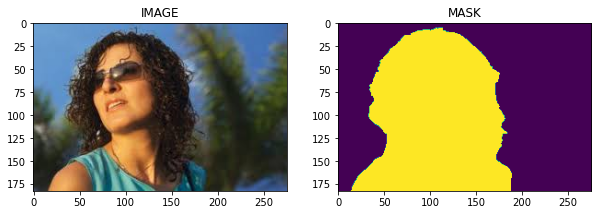

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [17]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [18]:
import albumentations as A

In [19]:
def get_train_augs():
  return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
  ])

In [20]:
from torch.utils.data import Dataset

In [21]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
      self.df = df
      self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
      
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #(h, w, c) -> (c, h, w)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [22]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [23]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


In [24]:
idx = 3

image, mask = trainset[idx]
#helper.show_image(image, mask)

In [25]:
from torch.utils.data import DataLoader

In [26]:
trainLoader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validLoader = DataLoader(validset, batch_size=BATCH_SIZE)

In [27]:
print(f"total no. of batches in trainLoader : {len(trainLoader)}")
print(f"total no. of batches in validLoader : {len(validLoader)}")

total no. of batches in trainLoader : 15
total no. of batches in validLoader : 4


In [28]:
for image,mask in trainLoader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


In [29]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [30]:
class SegmentationModel(nn.Module):

  def __init__(self):
      super(SegmentationModel, self).__init__()

      self.arc = smp.Unet(
          encoder_name = ENCODER,
          encoder_weights = WEIGHTS,
          in_channels = 3,
          classes = 1,
          activation = None
      )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [31]:
model = SegmentationModel()
model.to(DEVICE);

In [32]:
def train_fn(data_loader, model, optimizer):

  model.train() # switch to training mode, dropoout
  total_loss = 0.0

  for images, masks in tqdm(data_loader): # get batches of traning set

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()                      
    logits, loss = model(images, masks)      
    loss.backward()   
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [33]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

    return total_loss / len(data_loader)

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainLoader, model, optimizer)
  valid_loss = eval_fn(validLoader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('SAVED-MODEL')
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss: {train_loss} Valid_loss : {valid_loss}")

  0%|          | 0/15 [00:00<?, ?it/s]